In [ ]:
!pip install wandb kornia opacus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 1.2 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/anand-vishwakarma-1/differential_privacy.git

Cloning into 'dataset_reconstruction'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 76 (delta 14), reused 6 (delta 6), pack-reused 41
Receiving objects: 100% (76/76), 99.66 MiB | 14.72 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [ ]:
%cd dataset_reconstruction/

/content/dataset_reconstruction


In [ ]:
%%writefile settings.py
datasets_dir = './data/datasets'
results_base_dir = './runs'
models_dir = './models'

Writing settings.py


In [ ]:
!cp /content/drive/MyDrive/NYU/MLCS/projects/models/ex_models.zip .
!cp /content/drive/MyDrive/NYU/MLCS/projects/models/models.zip .
!unzip ex_models.zip -d .
!unzip models.zip -d .

Archive:  ex_models.zip
   creating: ./ex_models/
  inflating: ./ex_models/cifar10_dp2_ex.pth  
  inflating: ./ex_models/cifar10_ex.pth  
  inflating: ./ex_models/cifar_dp1_ex.pth  
  inflating: ./ex_models/mnist_dp1_ex.pth  
  inflating: ./ex_models/mnist_dp2_ex.pth  
  inflating: ./ex_models/mnist_ex.pth  
Archive:  models.zip
  inflating: ./models/cifar10.pth    
  inflating: ./models/cifar10_dp1.pth  
  inflating: ./models/cifar10_dp2.pth  
  inflating: ./models/mnist.pth      
  inflating: ./models/mnist_dp1.pth  
  inflating: ./models/mnist_dp2.pth  


In [ ]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from import_for_notebooks import *
torch.set_default_dtype(torch.float64)

import common_utils

import analysis
import analysis_utils
from analysis import find_nearest_neighbour, scale, sort_by_metric

In [ ]:
# read sweep parameters
mnist_sweep = common_utils.common.load_dict_to_obj("/content/dataset_reconstruction/reconstructions/mnist_odd_even/sweep.txt")
cifar10_sweep = common_utils.common.load_dict_to_obj("/content/dataset_reconstruction/reconstructions/cifar10_vehicles_animals/sweep.txt")

### MNIST Wihtout DP

In [ ]:
mnist_sweep.config["parameters"]["pretrained_model_path"]["value"] = 'mnist.pth'
mnist_sweep.pretrained_model_path = 'mnist.pth'
args, Xtrn, Ytrn, ds_mean, W, model = analysis_utils.sweep_get_data_model(mnist_sweep, put_in_sweep=True, run_train_test=True)

OUTPUT_DIR: ./runs/2023_12_21_22_15_27_613175_mnist_odd_even_d250
Namespace(cuda=True, seed=1, proj_name='', precision='double', run_mode='reconstruct', pretrained_model_path='./models/mnist.pth', train_save_model=True, train_save_model_every=-1, extract_save_results=True, extract_save_results_every=10000, save_args_files=True, wandb_active=False, wandb_project_name='Dataset_Extraction', wandb_entity='dataset_extraction', problem='mnist_odd_even', data_per_class_train=250, data_per_class_val=0, data_per_class_test=1000, data_reduce_mean=True, model_type='mlp', model_hidden_list=[1000, 1000], model_use_bias=False, use_init_scale=True, use_init_scale_only_first=True, model_init_list=[0.001, 0.001], model_train_activation='relu', train_epochs=1000, train_lr=0.01, train_evaluate_rate=1000, train_threshold=1e-40, train_SGD=False, train_SGD_batch_size=64, extraction_epochs=50000, extraction_data_amount_per_class=500, extraction_model_activation='modifiedrelu', extraction_model_relu_alpha=300

In [ ]:
x_paths = [
    '/content/dataset_reconstruction/ex_models/mnist_ex.pth'
]
X = torch.load(x_paths[0],map_location=torch.device('cpu'))

CUT the end of the zipped bla because it might have different shape before torch.cat
torch.Size([990, 1, 28, 28]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60


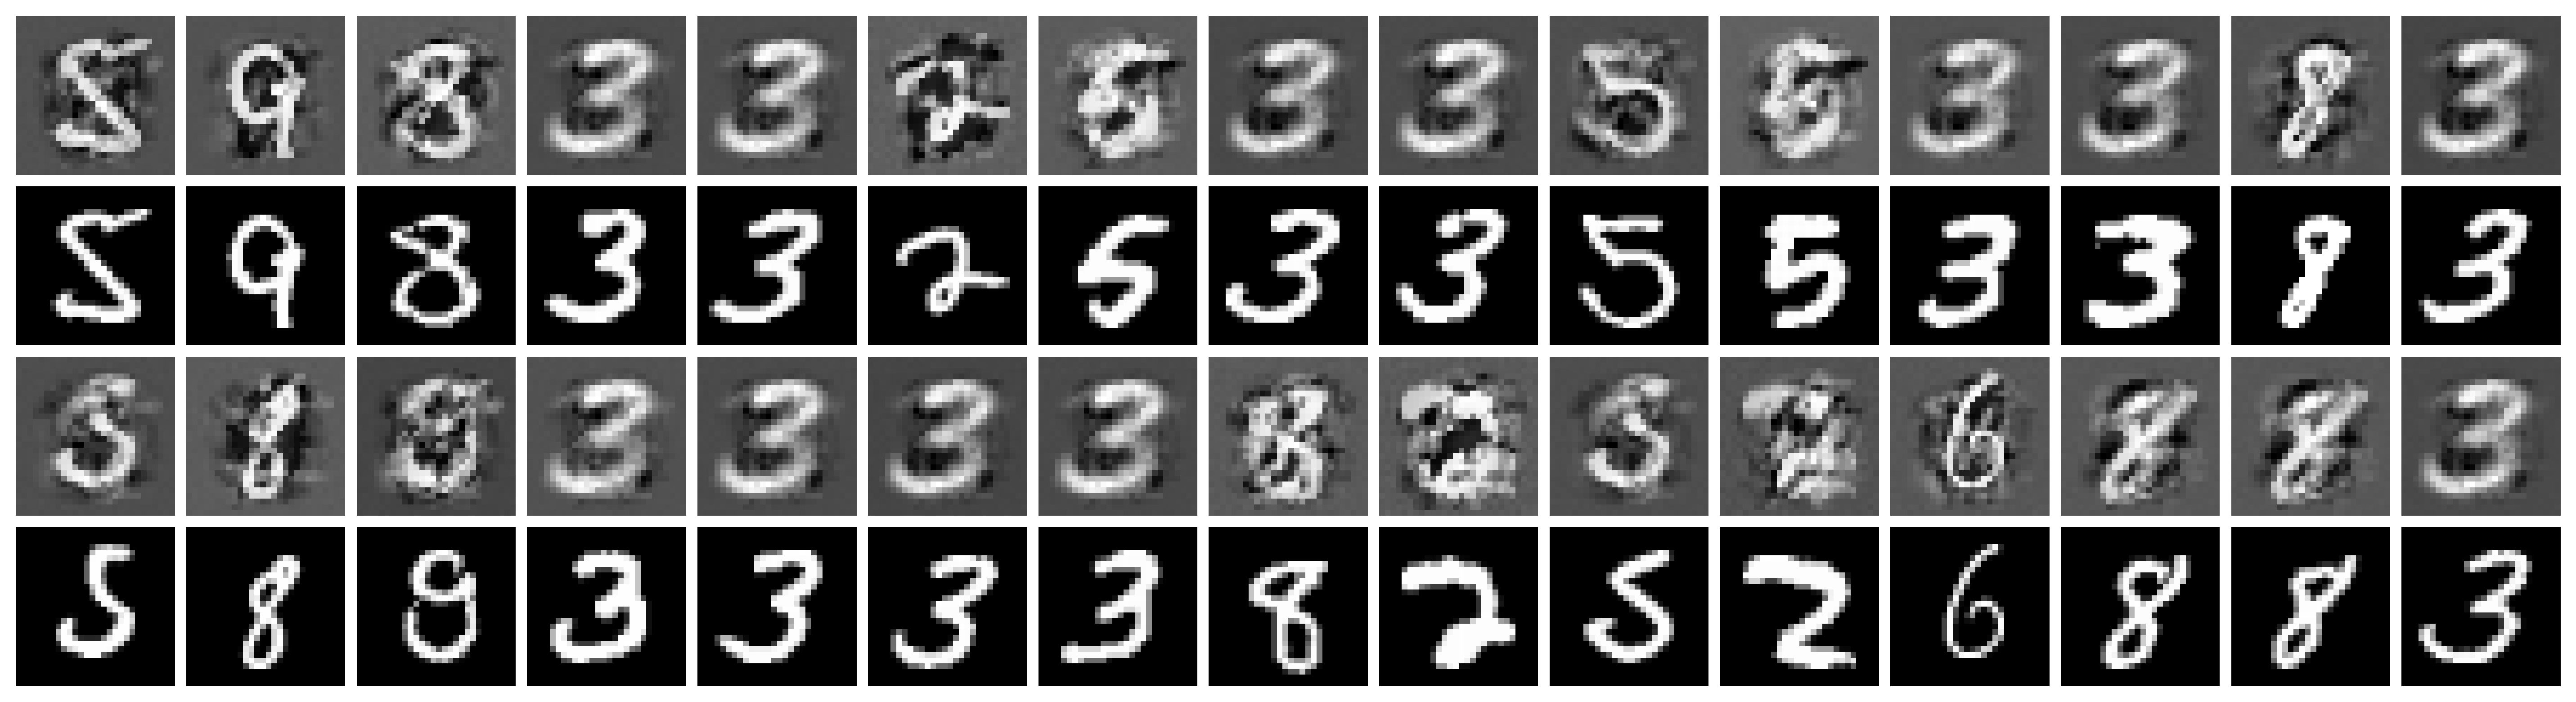

DONE!


In [ ]:
# Find "Good" Resonctructions (as detailed in Appendix B.3):

# Find Nearest Neighbour
xx1 = find_nearest_neighbour(X, Xtrn, search='ncc', vote='min', use_bb=False, nn_threshold=None)
# Scale to Images
xx_scaled, yy_scaled = scale(xx1, Xtrn, ds_mean)
# # Sort
xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')
values = model(Xtrn).data

# Plot
# color_by_labels = Ytrn[sort_idxs]
color_by_labels = None
figpath=None
analysis.plot_table(xx, yy, fig_elms_in_line=15, fig_lines_per_page=4, fig_type='one_above_another', color_by_labels=color_by_labels, figpath=figpath, show=True, dpi=100)

### MNIST Wiht DP setting 1

In [ ]:
mnist_sweep.config["parameters"]["pretrained_model_path"]["value"] = 'mnist_dp1.pth'
mnist_sweep.pretrained_model_path = 'mnist_dp1.pth'
args, Xtrn, Ytrn, ds_mean, W, model = analysis_utils.sweep_get_data_model(mnist_sweep, put_in_sweep=True, run_train_test=True)

OUTPUT_DIR: ./runs/2023_12_21_22_17_21_514259_mnist_odd_even_d250
Namespace(cuda=True, seed=1, proj_name='', precision='double', run_mode='reconstruct', pretrained_model_path='./models/mnist_dp1.pth', train_save_model=True, train_save_model_every=-1, extract_save_results=True, extract_save_results_every=10000, save_args_files=True, wandb_active=False, wandb_project_name='Dataset_Extraction', wandb_entity='dataset_extraction', problem='mnist_odd_even', data_per_class_train=250, data_per_class_val=0, data_per_class_test=1000, data_reduce_mean=True, model_type='mlp', model_hidden_list=[1000, 1000], model_use_bias=False, use_init_scale=True, use_init_scale_only_first=True, model_init_list=[0.001, 0.001], model_train_activation='relu', train_epochs=1000, train_lr=0.01, train_evaluate_rate=1000, train_threshold=1e-40, train_SGD=False, train_SGD_batch_size=64, extraction_epochs=50000, extraction_data_amount_per_class=500, extraction_model_activation='modifiedrelu', extraction_model_relu_alpha

In [ ]:
x_paths = [
    '/content/dataset_reconstruction/ex_models/mnist_dp1_ex.pth'
]
X = torch.load(x_paths[0],map_location=torch.device('cpu'))

CUT the end of the zipped bla because it might have different shape before torch.cat
torch.Size([990, 1, 28, 28]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60


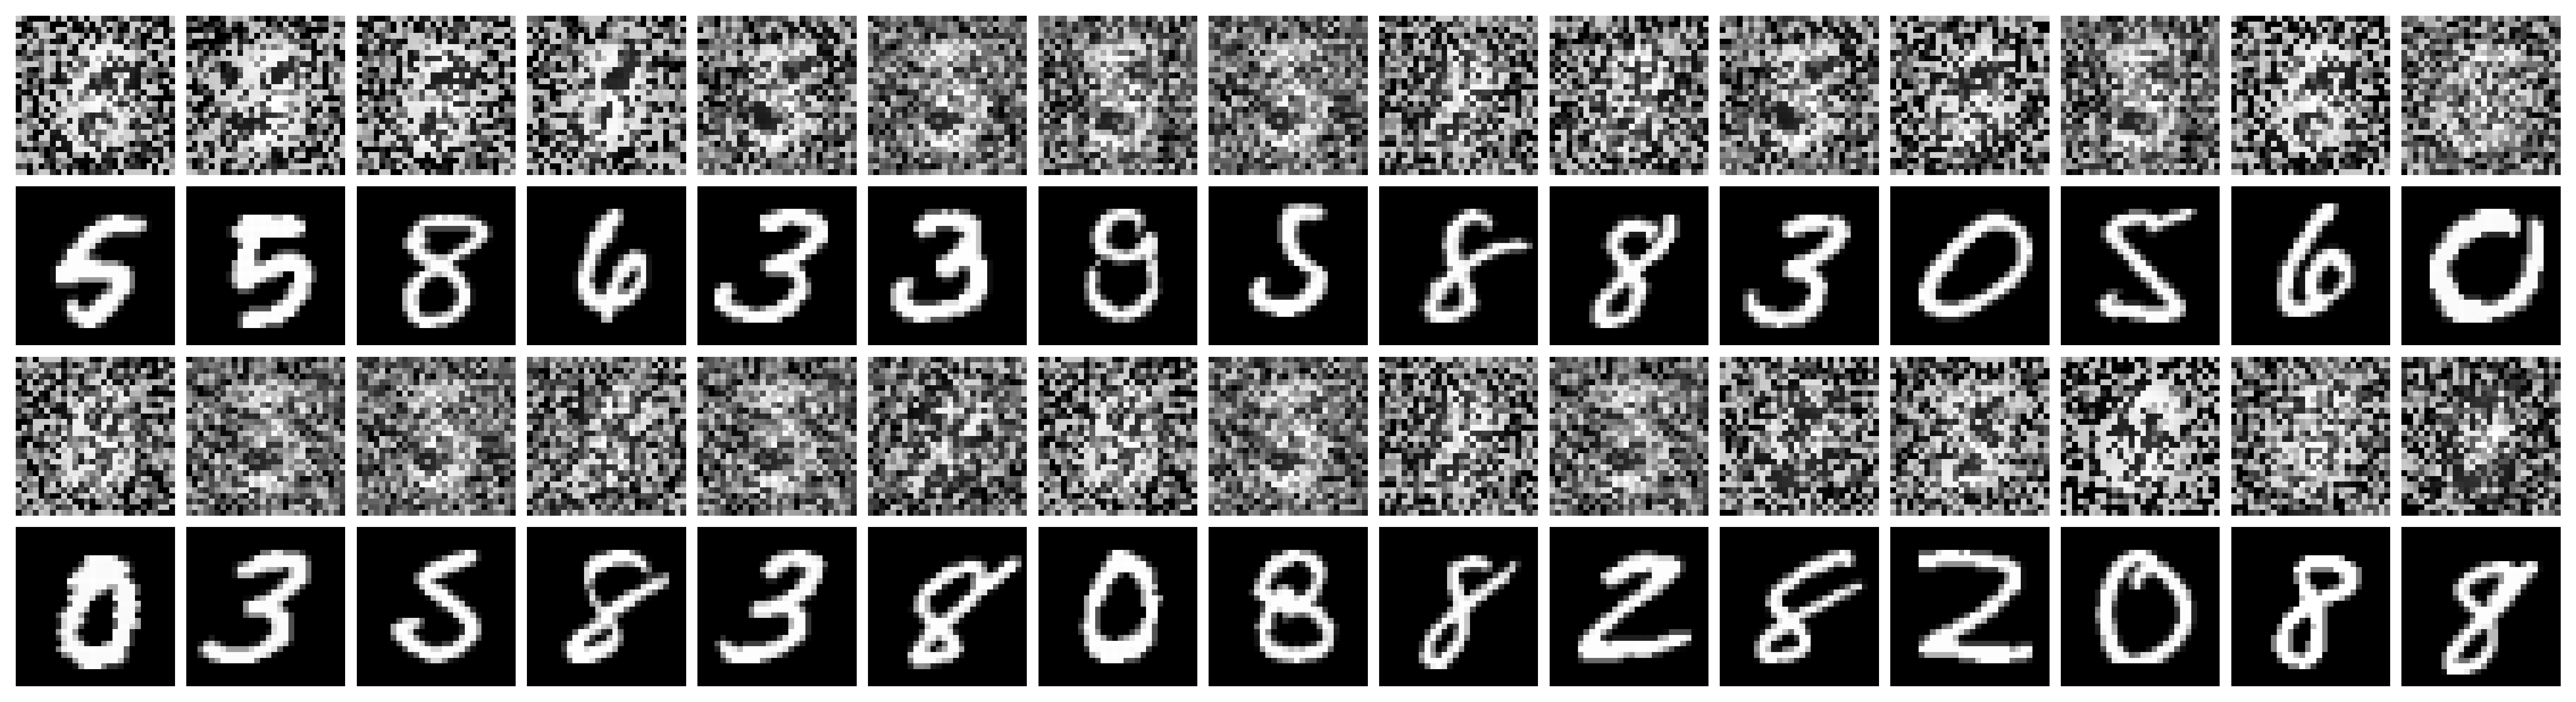

DONE!


In [ ]:
# Find "Good" Resonctructions (as detailed in Appendix B.3):

# Find Nearest Neighbour
xx1 = find_nearest_neighbour(X, Xtrn, search='ncc', vote='min', use_bb=False, nn_threshold=None)
# Scale to Images
xx_scaled, yy_scaled = scale(xx1, Xtrn, ds_mean)
# # Sort
xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')
values = model(Xtrn).data

# Plot
# color_by_labels = Ytrn[sort_idxs]
color_by_labels = None
figpath=None
analysis.plot_table(xx, yy, fig_elms_in_line=15, fig_lines_per_page=4, fig_type='one_above_another', color_by_labels=color_by_labels, figpath=figpath, show=True, dpi=100)

### MNIST With DP setting 2

In [ ]:
mnist_sweep.config["parameters"]["pretrained_model_path"]["value"] = 'mnist_dp2.pth'
mnist_sweep.config["parameters"]["model_hidden_list"]["value"] = "[1000,1000,1000,1000]"
mnist_sweep.config["parameters"]["model_init_list"]["value"] = "[0.001,0.001,0.001,0.001]"
mnist_sweep.pretrained_model_path = 'mnist_dp2.pth'
args, Xtrn, Ytrn, ds_mean, W, model = analysis_utils.sweep_get_data_model(mnist_sweep, put_in_sweep=True, run_train_test=True)

OUTPUT_DIR: ./runs/2023_12_21_22_24_01_556794_mnist_odd_even_d250
Namespace(cuda=True, seed=1, proj_name='', precision='double', run_mode='reconstruct', pretrained_model_path='./models/mnist_dp2.pth', train_save_model=True, train_save_model_every=-1, extract_save_results=True, extract_save_results_every=10000, save_args_files=True, wandb_active=False, wandb_project_name='Dataset_Extraction', wandb_entity='dataset_extraction', problem='mnist_odd_even', data_per_class_train=250, data_per_class_val=0, data_per_class_test=1000, data_reduce_mean=True, model_type='mlp', model_hidden_list=[1000, 1000, 1000, 1000], model_use_bias=False, use_init_scale=True, use_init_scale_only_first=True, model_init_list=[0.001, 0.001, 0.001, 0.001], model_train_activation='relu', train_epochs=1000, train_lr=0.01, train_evaluate_rate=1000, train_threshold=1e-40, train_SGD=False, train_SGD_batch_size=64, extraction_epochs=50000, extraction_data_amount_per_class=500, extraction_model_activation='modifiedrelu', e

In [ ]:
x_paths = [
    '/content/dataset_reconstruction/ex_models/mnist_dp2_ex.pth'
]
X = torch.load(x_paths[0],map_location=torch.device('cpu'))

CUT the end of the zipped bla because it might have different shape before torch.cat
torch.Size([990, 1, 28, 28]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60


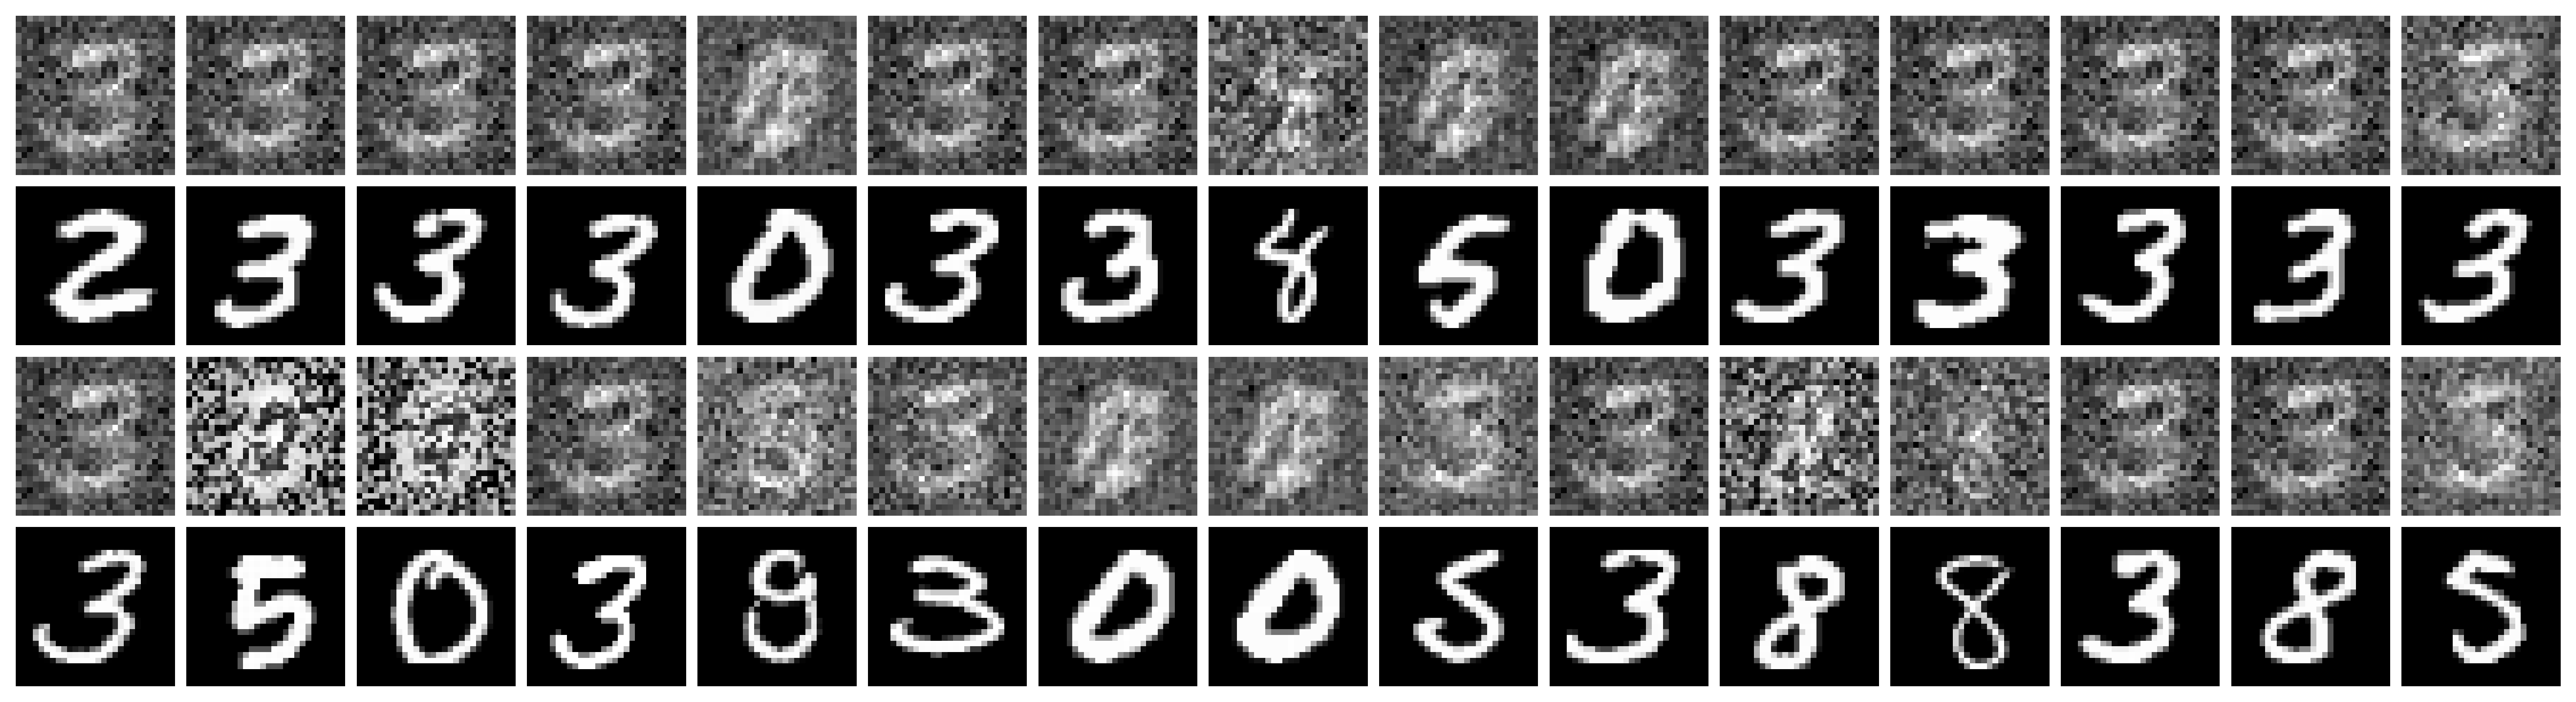

DONE!


In [ ]:
# Find "Good" Resonctructions (as detailed in Appendix B.3):

# Find Nearest Neighbour
xx1 = find_nearest_neighbour(X, Xtrn, search='ncc', vote='min', use_bb=False, nn_threshold=None)
# Scale to Images
xx_scaled, yy_scaled = scale(xx1, Xtrn, ds_mean)
# # Sort
xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')
values = model(Xtrn).data

# Plot
# color_by_labels = Ytrn[sort_idxs]
color_by_labels = None
figpath=None
analysis.plot_table(xx, yy, fig_elms_in_line=15, fig_lines_per_page=4, fig_type='one_above_another', color_by_labels=color_by_labels, figpath=figpath, show=True, dpi=100)

### CIFAR10 Without DP

In [ ]:
cifar10_sweep.config["parameters"]["pretrained_model_path"]["value"] = 'cifar10.pth'
cifar10_sweep.pretrained_model_path = 'cifar10.pth'
args, Xtrn, Ytrn, ds_mean, W, model = analysis_utils.sweep_get_data_model(cifar10_sweep, put_in_sweep=True, run_train_test=True)

OUTPUT_DIR: ./runs/2023_12_21_22_24_31_485795_cifar10_vehicles_animals_d250
Namespace(cuda=True, seed=1, proj_name='', precision='double', run_mode='reconstruct', pretrained_model_path='./models/cifar10.pth', train_save_model=True, train_save_model_every=-1, extract_save_results=True, extract_save_results_every=10000, save_args_files=True, wandb_active=False, wandb_project_name='Dataset_Extraction', wandb_entity='dataset_extraction', problem='cifar10_vehicles_animals', data_per_class_train=250, data_per_class_val=0, data_per_class_test=1000, data_reduce_mean=True, model_type='mlp', model_hidden_list=[1000, 1000], model_use_bias=False, use_init_scale=True, use_init_scale_only_first=True, model_init_list=[0.001, 0.001], model_train_activation='relu', train_epochs=1000, train_lr=0.01, train_evaluate_rate=1000, train_threshold=1e-40, train_SGD=False, train_SGD_batch_size=64, extraction_epochs=50000, extraction_data_amount_per_class=500, extraction_model_activation='modifiedrelu', extractio

In [ ]:
x_paths = [
    '/content/dataset_reconstruction/ex_models/cifar10_ex.pth'
]
X = torch.load(x_paths[0],map_location=torch.device('cpu'))

CUT the end of the zipped bla because it might have different shape before torch.cat
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60


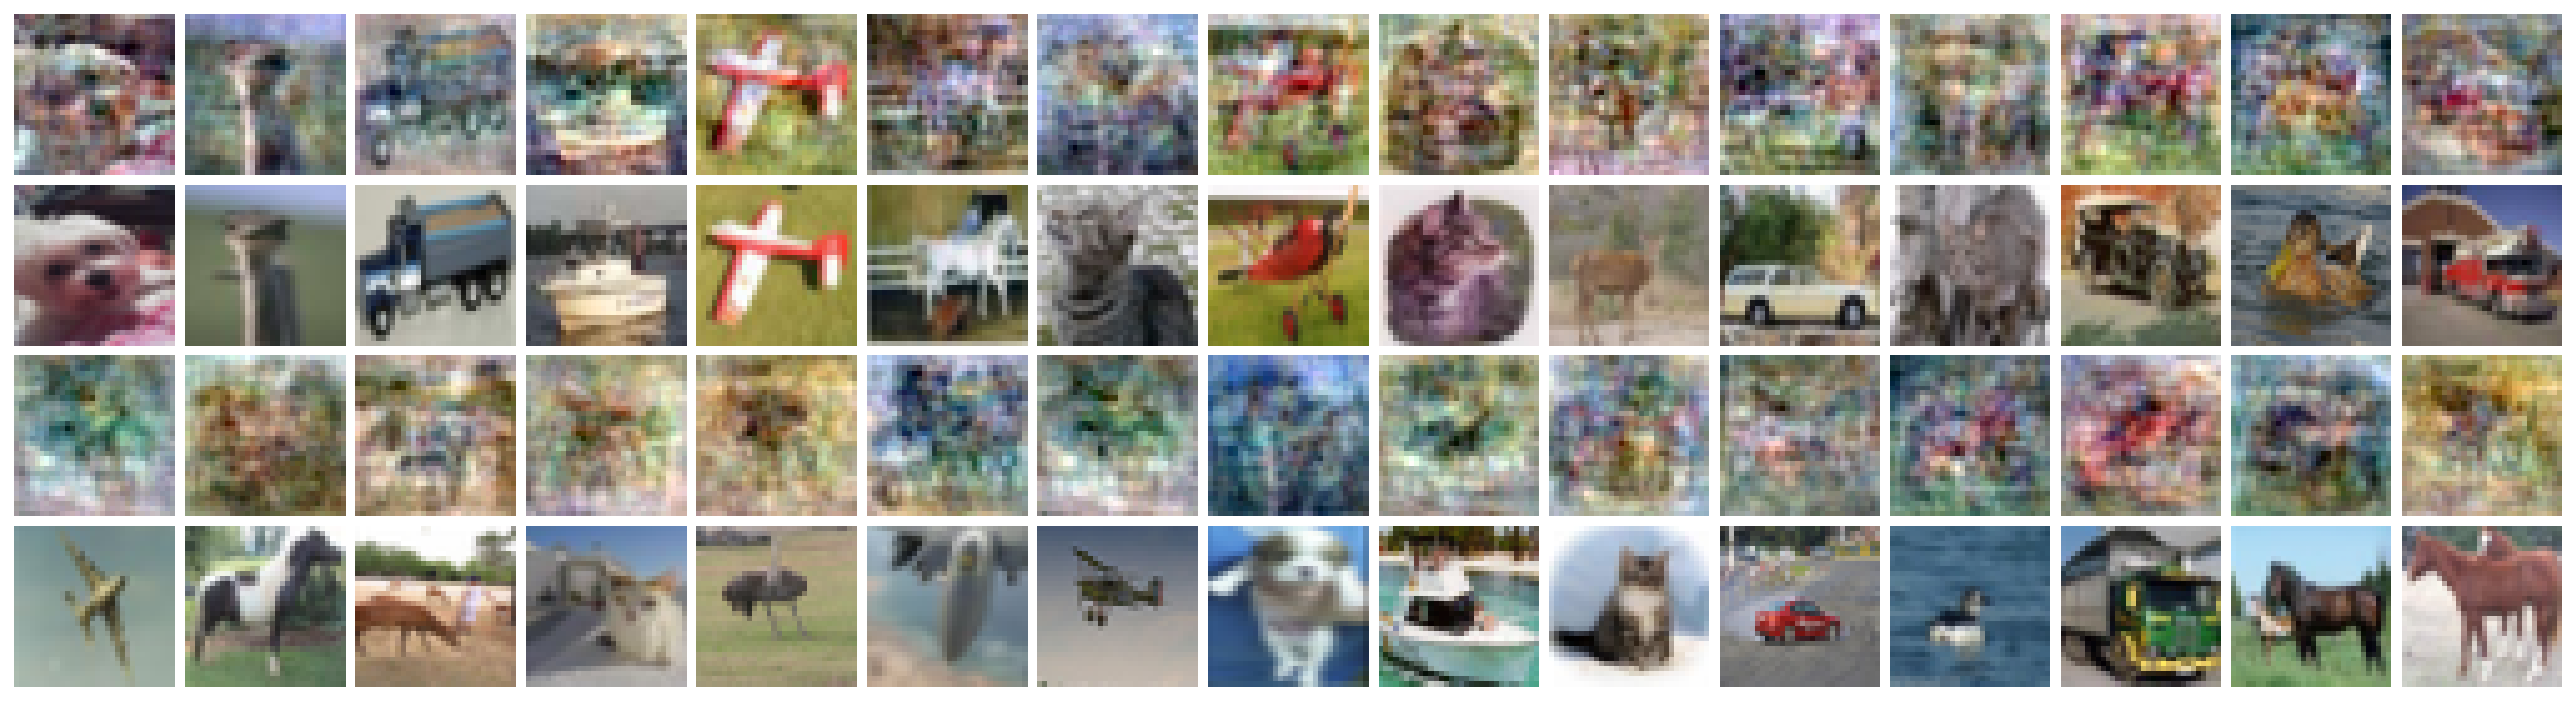

DONE!


In [ ]:
# Find "Good" Resonctructions (as detailed in Appendix B.3):

# Find Nearest Neighbour
xx1 = find_nearest_neighbour(X, Xtrn, search='ncc', vote='min', use_bb=False, nn_threshold=None)
# Scale to Images
xx_scaled, yy_scaled = scale(xx1, Xtrn, ds_mean)
# # Sort
xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')
values = model(Xtrn).data

# Plot
# color_by_labels = Ytrn[sort_idxs]
color_by_labels = None
figpath=None
analysis.plot_table(xx, yy, fig_elms_in_line=15, fig_lines_per_page=4, fig_type='one_above_another', color_by_labels=color_by_labels, figpath=figpath, show=True, dpi=100)

### CIFAR10 with DP setting 1

In [ ]:
cifar10_sweep.config["parameters"]["pretrained_model_path"]["value"] = 'cifar10_dp1.pth'
cifar10_sweep.pretrained_model_path = 'cifar10_dp1.pth'
args, Xtrn, Ytrn, ds_mean, W, model = analysis_utils.sweep_get_data_model(cifar10_sweep, put_in_sweep=True, run_train_test=True)

OUTPUT_DIR: ./runs/2023_12_21_22_25_08_517323_cifar10_vehicles_animals_d250
Namespace(cuda=True, seed=1, proj_name='', precision='double', run_mode='reconstruct', pretrained_model_path='./models/cifar10_dp1.pth', train_save_model=True, train_save_model_every=-1, extract_save_results=True, extract_save_results_every=10000, save_args_files=True, wandb_active=False, wandb_project_name='Dataset_Extraction', wandb_entity='dataset_extraction', problem='cifar10_vehicles_animals', data_per_class_train=250, data_per_class_val=0, data_per_class_test=1000, data_reduce_mean=True, model_type='mlp', model_hidden_list=[1000, 1000], model_use_bias=False, use_init_scale=True, use_init_scale_only_first=True, model_init_list=[0.001, 0.001], model_train_activation='relu', train_epochs=1000, train_lr=0.01, train_evaluate_rate=1000, train_threshold=1e-40, train_SGD=False, train_SGD_batch_size=64, extraction_epochs=50000, extraction_data_amount_per_class=500, extraction_model_activation='modifiedrelu', extra

In [ ]:
x_paths = [
    '/content/dataset_reconstruction/ex_models/cifar_dp1_ex.pth'
]
X = torch.load(x_paths[0],map_location=torch.device('cpu'))

CUT the end of the zipped bla because it might have different shape before torch.cat
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60


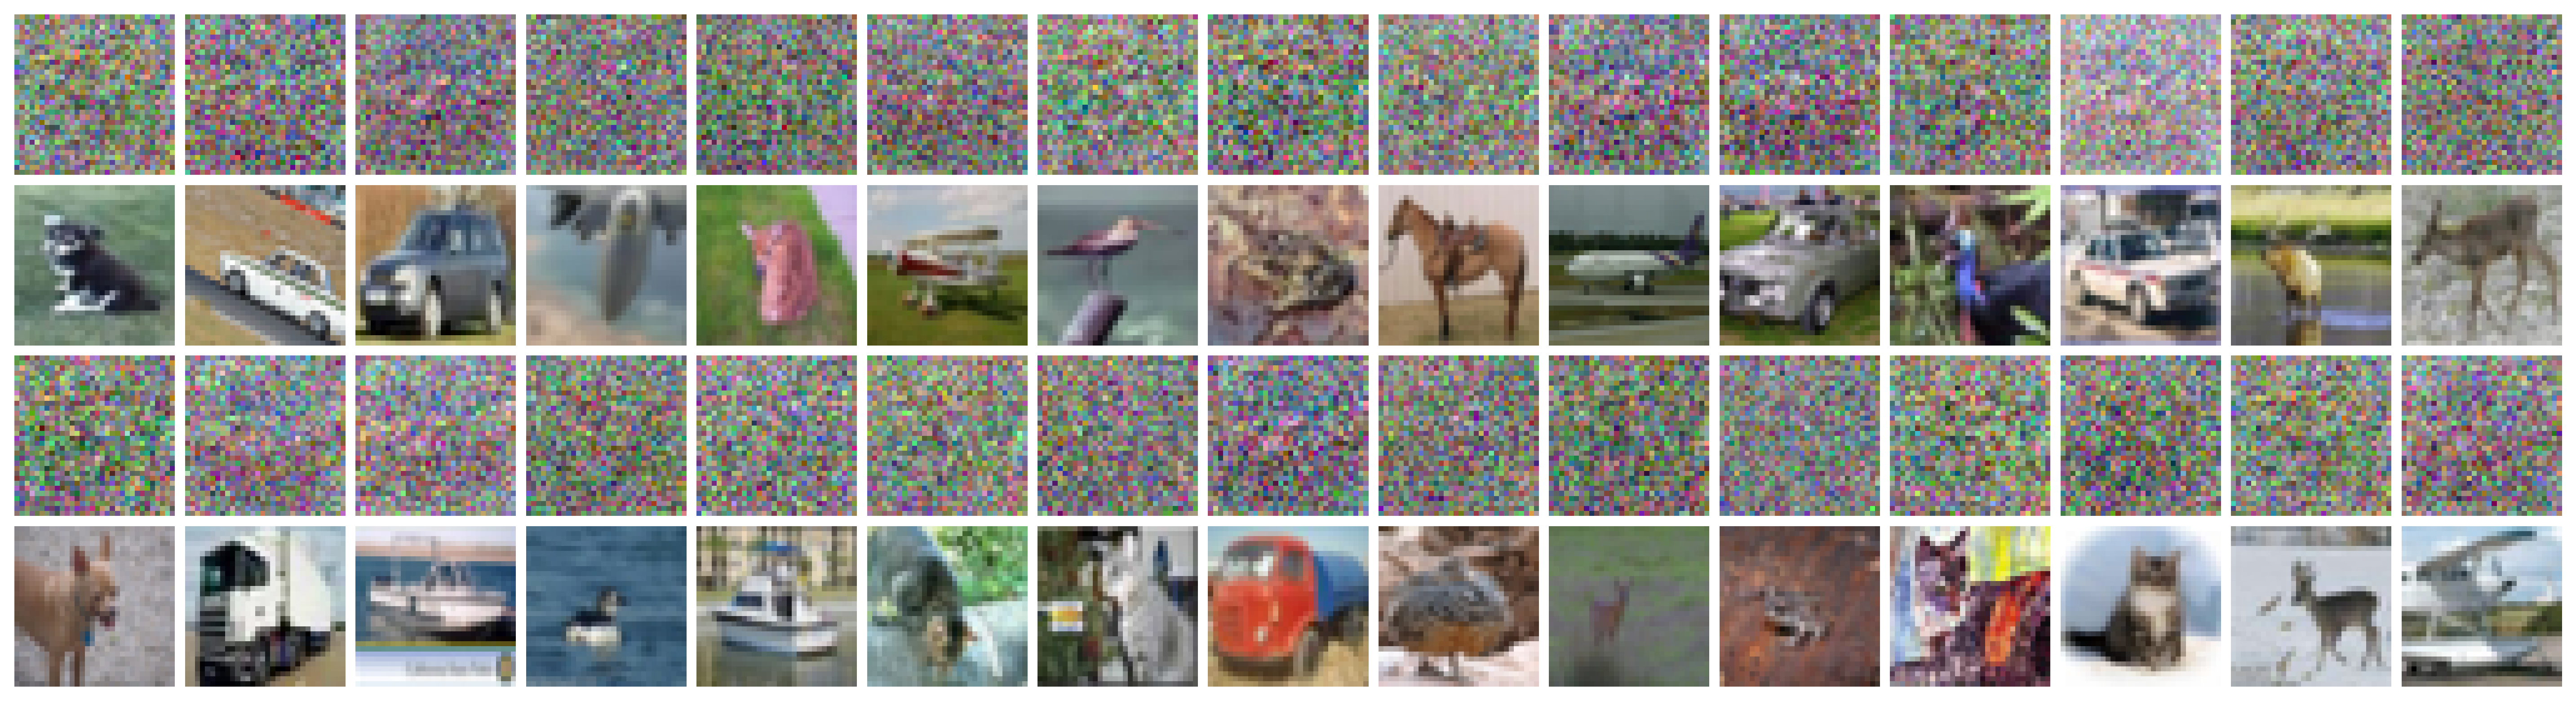

DONE!


In [ ]:
# Find "Good" Resonctructions (as detailed in Appendix B.3):

# Find Nearest Neighbour
xx1 = find_nearest_neighbour(X, Xtrn, search='ncc', vote='min', use_bb=False, nn_threshold=None)
# Scale to Images
xx_scaled, yy_scaled = scale(xx1, Xtrn, ds_mean)
# # Sort
xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')
values = model(Xtrn).data

# Plot
# color_by_labels = Ytrn[sort_idxs]
color_by_labels = None
figpath=None
analysis.plot_table(xx, yy, fig_elms_in_line=15, fig_lines_per_page=4, fig_type='one_above_another', color_by_labels=color_by_labels, figpath=figpath, show=True, dpi=100)

### MNIST Wihtout DP

In [ ]:
cifar10_sweep.config["parameters"]["pretrained_model_path"]["value"] = 'cifar10_dp2.pth'
cifar10_sweep.pretrained_model_path = 'cifar10_dp2.pth'
args, Xtrn, Ytrn, ds_mean, W, model = analysis_utils.sweep_get_data_model(cifar10_sweep, put_in_sweep=True, run_train_test=True)

OUTPUT_DIR: ./runs/2023_12_21_22_25_53_458437_cifar10_vehicles_animals_d250
Namespace(cuda=True, seed=1, proj_name='', precision='double', run_mode='reconstruct', pretrained_model_path='./models/cifar10_dp2.pth', train_save_model=True, train_save_model_every=-1, extract_save_results=True, extract_save_results_every=10000, save_args_files=True, wandb_active=False, wandb_project_name='Dataset_Extraction', wandb_entity='dataset_extraction', problem='cifar10_vehicles_animals', data_per_class_train=250, data_per_class_val=0, data_per_class_test=1000, data_reduce_mean=True, model_type='mlp', model_hidden_list=[1000, 1000], model_use_bias=False, use_init_scale=True, use_init_scale_only_first=True, model_init_list=[0.001, 0.001], model_train_activation='relu', train_epochs=1000, train_lr=0.01, train_evaluate_rate=1000, train_threshold=1e-40, train_SGD=False, train_SGD_batch_size=64, extraction_epochs=50000, extraction_data_amount_per_class=500, extraction_model_activation='modifiedrelu', extra

In [ ]:
x_paths = [
    '/content/dataset_reconstruction/ex_models/cifar10_dp2_ex.pth'
]
X = torch.load(x_paths[0],map_location=torch.device('cpu'))

CUT the end of the zipped bla because it might have different shape before torch.cat
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60


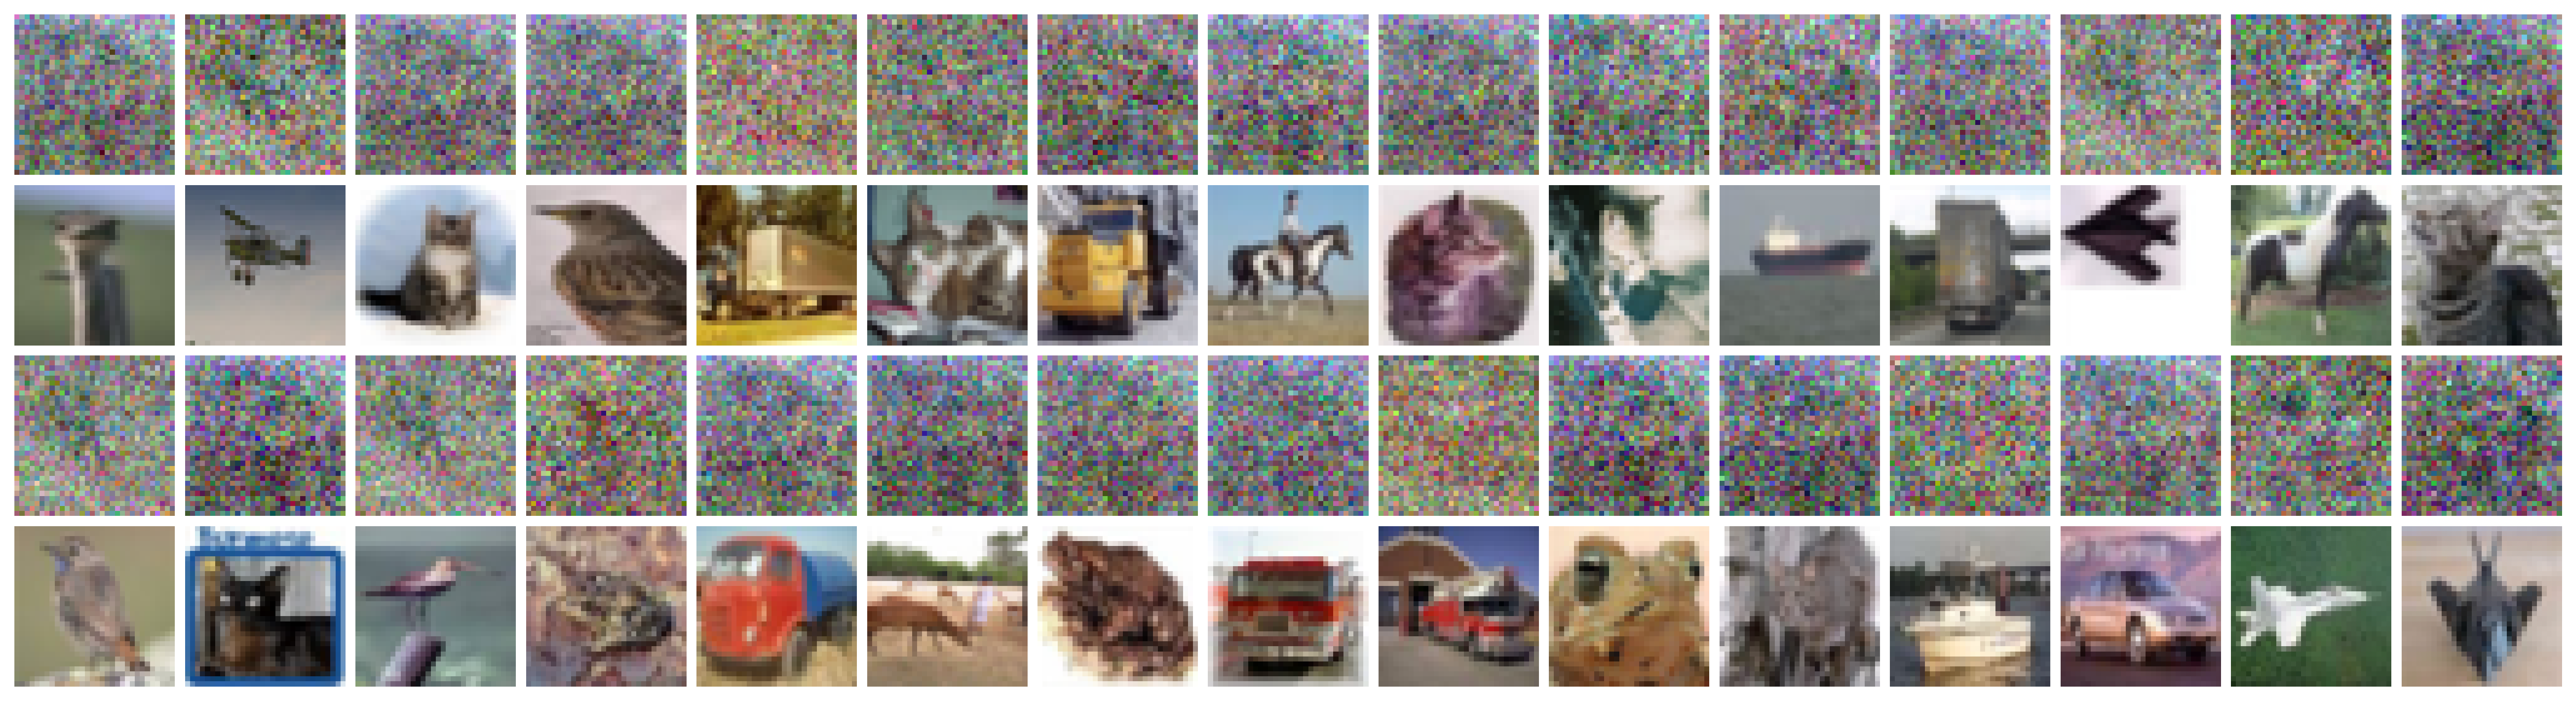

DONE!


In [ ]:
# Find "Good" Resonctructions (as detailed in Appendix B.3):

# Find Nearest Neighbour
xx1 = find_nearest_neighbour(X, Xtrn, search='ncc', vote='min', use_bb=False, nn_threshold=None)
# Scale to Images
xx_scaled, yy_scaled = scale(xx1, Xtrn, ds_mean)
# # Sort
xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')
values = model(Xtrn).data

# Plot
# color_by_labels = Ytrn[sort_idxs]
color_by_labels = None
figpath=None
analysis.plot_table(xx, yy, fig_elms_in_line=15, fig_lines_per_page=4, fig_type='one_above_another', color_by_labels=color_by_labels, figpath=figpath, show=True, dpi=100)